# Text vectorisation: Turning Text into Features

More advanced forms of text analysis require that text documents are converted into numerical values or features. In this  section we will examine:

* different methods for representing a collection of texts as numbers
* the decisions we need to make when generating a particular representation as well as the kinds of insights each numerical representation can give us.

We will use tools from the Python libraries `scikit-learn` and `gensim` to perform some popular text vectorisation methods:
* Re-cap of N-grams (unigram and bi-gram) term friquency
* TF-IDF (Term Frequency–Inverse Document Frequency)
* Word embedding—Word2Vec

In [1]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec

from matplotlib import pyplot as plt

## Turning text into n-grams features 
### Unigrams

Compute the friquency of word occurance using count vectoriser in `scikit-learn`  

### Toy example

In [2]:
# Text corpus

# Load the parsed news dataset 
corpus = pd.read_csv('sample_news_large_phrased.csv', index_col='index')

In [3]:
corpus.head(1)

,query,title,text,published,site,tokens
index,,,,,,
0,Hong Kong,Horrifying view of fires from space,Video Image Satellite images show insane view ...,2019-11-08T23:51:00.000+02:00,news.com.au,video|*|image|*|satellite|*|image|*|insane|*|v...


In [4]:
# Subset news stories about brexit
corpus_brexit = corpus[corpus['query']=='brexit']

corpus_toy=corpus_brexit.iloc[[7,22], [1]]

# Set the maximum width of columns
pd.options.display.max_colwidth = 200

corpus_toy.head(5)

,title
index,
132,Brexit news: Gina Miller unveils new Remainer plot to block Brexit in general election | UK | News | Express.co.uk
147,Brexit news: Labour pledge to continue ‘freedom of movement’ infuriates Leavers | UK | News | Express.co.uk


In [5]:
# Use CountVectorizer to tokenize a collection of text documents and convert it into a matrix of token counts

# Create an instance of the CountVectorizer class
vectorizer = CountVectorizer()

# Learn the vocabulary from the corpus using the toy corpus
vectorizer.fit(corpus_toy['title'])

# encode documents as vectors
vector = vectorizer.transform(corpus_toy['title'])

# The vocabulary_ attribute maps the tokens (keys) to the integer feature indices (values) in a dictionary
print(vectorizer.vocabulary_)

{'brexit': 1, 'news': 16, 'gina': 8, 'miller': 13, 'unveils': 23, 'new': 15, 'remainer': 20, 'plot': 19, 'to': 21, 'block': 0, 'in': 9, 'general': 7, 'election': 4, 'uk': 22, 'express': 5, 'co': 2, 'labour': 11, 'pledge': 18, 'continue': 3, 'freedom': 6, 'of': 17, 'movement': 14, 'infuriates': 10, 'leavers': 12}


Note that punctuation and single letter's words are removed. We will use below the prerpocessed tokens you have already preprocessed.

In [6]:
# Access the feature index of a token
vectorizer.vocabulary_.get('brexit')

1

The numbers assigned to each token (e.g., "brexit") are indices. For clarity, indices are sorted in the cell bellow.

In [7]:
# Print the matrix of rows (documents) and columns (count for the number of times a token appeared in the document) 
print(vector.toarray())

[[1 2 1 0 1 1 0 1 1 1 0 0 0 1 0 1 2 0 0 1 1 1 2 1]
 [0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 2 1 1 0 0 1 2 0]]


`vector.toarray()` returns a matrix where the rows indicate the number of documents (two in our case) and the columns indicate the size of the vocabulary of the entire corpus (all documents).

Each document is encoded as a vector with a length indicating the size of the vocabulary of the entire corpus and an integer count for the number of times each token appeared in the document.

In [8]:
# Sort the dictionary of terms (keys) and indices (values) in the feature matrix by values in ascending order
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))
print(vector.toarray())

{'block': 0, 'brexit': 1, 'co': 2, 'continue': 3, 'election': 4, 'express': 5, 'freedom': 6, 'general': 7, 'gina': 8, 'in': 9, 'infuriates': 10, 'labour': 11, 'leavers': 12, 'miller': 13, 'movement': 14, 'new': 15, 'news': 16, 'of': 17, 'pledge': 18, 'plot': 19, 'remainer': 20, 'to': 21, 'uk': 22, 'unveils': 23}
[[1 2 1 0 1 1 0 1 1 1 0 0 0 1 0 1 2 0 0 1 1 1 2 1]
 [0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 2 1 1 0 0 1 2 0]]


The output consists of 24 unigram features. The 1st token `brexit` has appeared twice in the first title and once in the second title.

In [9]:
# Find (1) the most friquent token in a document, (2) the number of times it appears in that document 
# and (3) the document in which it appears
maximum = vector.toarray().max()
index_of_maximum = np.where(vector.toarray() == maximum)

print("max:", maximum)
print("index:", index_of_maximum)

max: 2
index: (array([0, 0, 0, 1, 1]), array([ 1, 16, 22, 16, 22]))


In [10]:
# Sort the vector of integer count in ascending order
np.sort(vector.toarray())

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2]])

### Example using the entire data set of News Tokens

In [11]:
corpus['text'].head()

index
0    Video Image Satellite images show insane view of NSW fires from space Satellite images show the huge amount of smoke billowing from a number of bushfires across NSW.\nThe NSW fires, as seen from s...
1    \n Chief Executive addresses the press after citywide chaos and transport disruptions \n Earlier, police shoot protester leaving him in intensive care, while separately, a man is set on fire durin...
2    Hong Kong (CNN) China has announced a curfew on online gaming for minors among new measures aimed at curbing video game addiction.\nThe official government guidelines will be applied to all online...
3    Washington (CNN) President Donald Trump was relentlessly dishonest last week about the scandal over his dealings with Ukraine, making false claims about just about every component of the story.\nT...
4    (CNN) — What is bread? You likely don't have to think for long, and whether you're hungry for a slice of sourdough or craving some tortillas, what you imagine says a lot

In [12]:
# Convert a collection of text documents to a matrix of token counts

vectorizer_corpus = CountVectorizer()

#  Learn the vocabulary from the corpus and tokenise
vectorizer_corpus.fit(corpus['text'])

# encode documents as vectors
vector_corpus = vectorizer_corpus.transform(corpus['text'])

# summarize and print output
print(dict(sorted(vectorizer_corpus.vocabulary_.items(), key=lambda item: item[1])))

{'00': 0, '000': 1, '0002': 2, '000th': 3, '0010': 4, '0044': 5, '01': 6, '013': 7, '02': 8, '020': 9, '03': 10, '04': 11, '04c76inq0a': 12, '05': 13, '056': 14, '05am': 15, '06': 16, '07': 17, '08': 18, '0800': 19, '09': 20, '0944': 21, '0iiwtfu5gq': 22, '0s': 23, '10': 24, '100': 25, '1000': 26, '100m': 27, '101': 28, '102': 29, '103': 30, '104': 31, '105': 32, '106': 33, '106619': 34, '107': 35, '108': 36, '109': 37, '109554': 38, '10am': 39, '10k': 40, '10pm': 41, '10th': 42, '11': 43, '110': 44, '110541': 45, '111': 46, '112': 47, '113': 48, '114': 49, '115': 50, '116': 51, '117': 52, '117513': 53, '118': 54, '1187098428737753091': 55, '119': 56, '11th': 57, '12': 58, '120': 59, '1200': 60, '121': 61, '121647': 62, '122': 63, '123': 64, '124': 65, '125': 66, '126': 67, '127': 68, '128': 69, '129': 70, '12bn': 71, '12m': 72, '12th': 73, '13': 74, '130': 75, '131': 76, '132': 77, '132m': 78, '133': 79, '134': 80, '135': 81, '136': 82, '137': 83, '138': 84, '139': 85, '13am': 86, '14

In [13]:
print(vector_corpus.toarray())

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
# Dimensions of vector_corpus.toarray(), i.e., number of rows and columns
vector_corpus.toarray().shape

(175, 14322)

## Exercise 1

Using the entire corpus, find (1) the most friquent token in a document, (2) the number of times it appears in that document and (3) the document in which it appears.

In [15]:
# Please write below the code for Exercise 1
# Find the most friquent token in the corpus and the number of times it appeared in the corpus 

maximum = vector_corpus.toarray().max()
index_of_maximum = np.where(vector_corpus.toarray() == maximum)

print("max:", maximum)
print("token index:", index_of_maximum)

max: 573
token index: (array([3]), array([12823]))


The the most frequent token is in document 3 and indexed 12823. 

In [16]:
# Find the token indexed 12823 by get a key in a dictionary by its value 
# The value in the "vectorizer_corpus.vocabulary_" is the token index

dict((v,k) for k,v in vectorizer_corpus.vocabulary_.items())[12823]

'the'

In [17]:
# To double check, get value by key

vectorizer_corpus.vocabulary_.get('the')

12823

### Bi-grams (combination of two tokens)
In the unigram transformation, each token is a feature. For example, `general` and `election` are two separate features. The bi-gram transformation relaxes this contrain by pairing each word to previous and subsequent words.  

In [18]:
# Extracting unigrams and bigrams
    # ngram_range of (1, 1) extracts unigrams
    # ngram_range of (1, 2) extracts unigrams and bigrams
    # ngram_range of (1, 2) extracts bigrams

# Create an instance of the CountVectorizer class set bigram extraction   
vectorizer = CountVectorizer(ngram_range=(2,2))

# Learn the vocabulary from the corpus and tokenise
vectorizer.fit(corpus_toy['title'])

# encode documents as vectors
vector = vectorizer.transform(corpus_toy['title'])

# # The vocabulary_ attribute maps the tokens (keys) to the integer feature indices (values) in a dictionary
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))
print(vector.toarray())

{'block brexit': 0, 'brexit in': 1, 'brexit news': 2, 'co uk': 3, 'continue freedom': 4, 'election uk': 5, 'express co': 6, 'freedom of': 7, 'general election': 8, 'gina miller': 9, 'in general': 10, 'infuriates leavers': 11, 'labour pledge': 12, 'leavers uk': 13, 'miller unveils': 14, 'movement infuriates': 15, 'new remainer': 16, 'news express': 17, 'news gina': 18, 'news labour': 19, 'of movement': 20, 'pledge to': 21, 'plot to': 22, 'remainer plot': 23, 'to block': 24, 'to continue': 25, 'uk news': 26, 'unveils new': 27}
[[1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1]
 [0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0]]


The output consists of 28 bigram-based features. The count is either 1 or 0 for each of our bigram.     

##  Term frequency–inverse document frequency (TF-IDF)

TF-IDF vectorisation weights down tokens that are present across many documents in the corpus (in particular, words like "of" and "the" if stop words are not removed) and are therefore less informative than tokens that are present in specific documents in the corpus. 

### Toy example

In [19]:
# Convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer()

# Learn the vocabulary from the corpus and tokenise
vectorizer.fit(corpus_toy['title'])

# Summarize & print the tokens and the matrix of TF-IDF features 
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))
print(vectorizer.idf_)

{'block': 0, 'brexit': 1, 'co': 2, 'continue': 3, 'election': 4, 'express': 5, 'freedom': 6, 'general': 7, 'gina': 8, 'in': 9, 'infuriates': 10, 'labour': 11, 'leavers': 12, 'miller': 13, 'movement': 14, 'new': 15, 'news': 16, 'of': 17, 'pledge': 18, 'plot': 19, 'remainer': 20, 'to': 21, 'uk': 22, 'unveils': 23}
[1.40546511 1.         1.         1.40546511 1.40546511 1.
 1.40546511 1.40546511 1.40546511 1.40546511 1.40546511 1.40546511
 1.40546511 1.40546511 1.40546511 1.40546511 1.         1.40546511
 1.40546511 1.40546511 1.40546511 1.         1.         1.40546511]


###### How is TF-IDF computed by `scikit-learn`?  

In [20]:
# TF-IDF 
# IDF = log(1 + N/ 1 + n) + 1 
# N is the total number of documents 
# n is the number of documents in which the word appears
# constant “1” is added to the numerator and denominator to prevent zero divisions
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    
import math as m
# the term "brexit" is present in two of two documents
m.log((2+1)/(2+1))+1 

1.0

In [21]:
# the term "election" is present in one of two documents
m.log((2+1)/(1+1))+1

1.4054651081081644

#### TF-IDF vectorisation of the `row` news sub-corpus related to Brexit

In [22]:
# Convert our corpus of row documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer()

# Learn the vocabulary from the corpus and tokenise
vectorizer.fit(corpus_brexit['text'])

# Summarize & print the tokens and the matrix of TF-IDF features
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))
print(vectorizer.idf_)

{'00': 0, '000': 1, '0010': 2, '0044': 3, '01': 4, '020': 5, '05': 6, '056': 7, '05am': 8, '06': 9, '07': 10, '08': 11, '0800': 12, '0944': 13, '10': 14, '100': 15, '10am': 16, '10pm': 17, '11': 18, '115': 19, '11th': 20, '12': 21, '12bn': 22, '13': 23, '13am': 24, '14': 25, '15': 26, '150': 27, '158': 28, '16': 29, '166': 30, '17': 31, '18': 32, '19': 33, '190': 34, '1939': 35, '1940': 36, '1956': 37, '1966': 38, '1969': 39, '1978': 40, '1979': 41, '1982': 42, '1983': 43, '1984': 44, '1985': 45, '1991': 46, '1993': 47, '1995': 48, '1998': 49, '20': 50, '2000': 51, '2003': 52, '2006': 53, '2009': 54, '2010': 55, '2012': 56, '2013': 57, '2016': 58, '2017': 59, '2019': 60, '2020': 61, '2021': 62, '2027': 63, '207': 64, '21': 65, '218': 66, '22': 67, '23': 68, '24': 69, '25': 70, '25c': 71, '268': 72, '27': 73, '277': 74, '28': 75, '29': 76, '299': 77, '2am': 78, '30': 79, '306': 80, '308': 81, '30am': 82, '30pm': 83, '31': 84, '322': 85, '329': 86, '33': 87, '3490': 88, '35': 89, '37': 9

In [23]:
# TF-IDF of the token "the" in the brexit corpus
print("TF-IDF score of the term 'the':",vectorizer.idf_[vectorizer.vocabulary_["the"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

TF-IDF score of the term 'the': 1.0800427076735364
Mean TF-IDF in corpus: 3.2954390591304894


In [24]:
# TF-IDF of the token "brexit" in the brexit corpus
print("TF-IDF score of the term 'brexit':",vectorizer.idf_[vectorizer.vocabulary_["brexit"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

TF-IDF score of the term 'brexit': 1.1226023220923322
Mean TF-IDF in corpus: 3.2954390591304894


In [25]:
# TF-IDF of the token "deal" in the brexit corpus
print("TF-IDF score of the term 'deal':",vectorizer.idf_[vectorizer.vocabulary_["deal"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

TF-IDF score of the term 'deal': 1.424883193965266
Mean TF-IDF in corpus: 3.2954390591304894


In [26]:
# TF-IDF of the token "protesters" in the brexit corpus
print("TF-IDF score of the term 'protesters':", vectorizer.idf_[vectorizer.vocabulary_["protesters"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

TF-IDF score of the term 'protesters': 3.159484249353372
Mean TF-IDF in corpus: 3.2954390591304894


The word `"the"` is present in many documents and hence the vector value is close to 1; Converseley, the term `"protesters"` is present in few documents and has a higher vector value. 

#### Let's explore some parameters of the TfidfVectorizer function

In [27]:
# Key parameters of the TfidfVectorizer function
    # min_df: float or int, default=1.0. ignores terms that have a document frequency lower than the given threshold
    # max_df: float or int, default=1.0. ignores terms that have a document frequency higher than the given threshold
    # stop_words: removes stopwords, only for english, with issues; max_df set to a value in the range [0.7, 1.0) 
    # automatically filters stop words based on intra corpus document frequency of terms.

# Convert our corpus of row documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', min_df = 0.2, max_df = 0.9) # threshold depends on corpus and question

# Learn the vocabulary from the corpus and tokenise
vectorizer.fit(corpus_brexit['text'])

# Summarize & print the tokens and the matrix of TF-IDF features
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))
print(vectorizer.idf_)

{'10': 0, '12': 1, '2019': 2, '25': 3, '30': 4, '31': 5, 'added': 6, 'agreed': 7, 'agreement': 8, 'argued': 9, 'articles': 10, 'ask': 11, 'asked': 12, 'backing': 13, 'bbc': 14, 'believe': 15, 'boris': 16, 'brexit': 17, 'britain': 18, 'british': 19, 'business': 20, 'called': 21, 'change': 22, 'clear': 23, 'come': 24, 'comments': 25, 'commons': 26, 'conservative': 27, 'countries': 28, 'country': 29, 'day': 30, 'days': 31, 'dead': 32, 'deadline': 33, 'deal': 34, 'debate': 35, 'december': 36, 'decision': 37, 'described': 38, 'despite': 39, 'did': 40, 'different': 41, 'doesn': 42, 'don': 43, 'donald': 44, 'election': 45, 'end': 46, 'eu': 47, 'european': 48, 'extension': 49, 'family': 50, 'free': 51, 'future': 52, 'general': 53, 'getty': 54, 'going': 55, 'good': 56, 'government': 57, 'group': 58, 'half': 59, 'happen': 60, 'happens': 61, 'hard': 62, 'home': 63, 'hours': 64, 'house': 65, 'image': 66, 'including': 67, 'interview': 68, 'jeremy': 69, 'john': 70, 'johnson': 71, 'just': 72, 'know':

In [29]:
# TF-IDF of the token "the" in the brexit corpus
print("TF-IDF score of the term 'the':",vectorizer.idf_[vectorizer.vocabulary_["the"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

KeyError: 'the'

The word `"the"` appears in more than 90% of the documents and is removed on that basis.   

In [30]:
# TF-IDF of the token "brexit" in the brexit corpus
print("TF-IDF score of the term 'brexit':",vectorizer.idf_[vectorizer.vocabulary_["brexit"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

TF-IDF score of the term 'brexit': 1.1226023220923322
Mean TF-IDF in corpus: 2.1845818517131215


In [31]:
# TF-IDF of the token "deal" in the brexit corpus
print("TF-IDF score of the term 'deal':",vectorizer.idf_[vectorizer.vocabulary_["deal"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

TF-IDF score of the term 'deal': 1.424883193965266
Mean TF-IDF in corpus: 2.1845818517131215


In [32]:
# TF-IDF of the token "election" in the brexit corpus
print("TF-IDF score of the term 'election':", vectorizer.idf_[vectorizer.vocabulary_["protesters"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

KeyError: 'protesters'

The word `"protesters"` appears in less than 20% of the documents and is removed on that basis.

#### TF-IDF vectorisation using the `tokenied` News sub-corpus related to Brexit

In [33]:
vectorizer = TfidfVectorizer(stop_words='english', min_df = 0.2, max_df = 0.9) # threshold depends on corpus and question
#Tokenize and build vocab
vectorizer.fit(corpus_brexit['tokens'])
#Summarize
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))
print(vectorizer.idf_)

{'accuse': 0, 'act': 1, 'add': 2, 'agree': 3, 'agreement': 4, 'allow': 5, 'announce': 6, 'argue': 7, 'ask': 8, 'attack': 9, 'attempt': 10, 'bbc': 11, 'believe': 12, 'big': 13, 'boris_johnson': 14, 'break': 15, 'brexit': 16, 'brexit_deal': 17, 'britain': 18, 'british': 19, 'business': 20, 'campaign': 21, 'carry': 22, 'change': 23, 'claim': 24, 'clear': 25, 'close': 26, 'come': 27, 'comment': 28, 'commons': 29, 'conservative': 30, 'continue': 31, 'country': 32, 'day': 33, 'dead': 34, 'deadline': 35, 'deal': 36, 'debate': 37, 'december': 38, 'decision': 39, 'demand': 40, 'despite': 41, 'die': 42, 'different': 43, 'drive': 44, 'early': 45, 'election': 46, 'end': 47, 'eu': 48, 'european': 49, 'european_union': 50, 'extension': 51, 'extra': 52, 'face': 53, 'family': 54, 'feel': 55, 'force': 56, 'free': 57, 'future': 58, 'general_election': 59, 'good': 60, 'government': 61, 'group': 62, 'half': 63, 'happen': 64, 'hard': 65, 'hold': 66, 'home': 67, 'hope': 68, 'hour': 69, 'house_of_commons': 7

In [34]:
# TF-IDF of the token "the" in the brexit corpus
print("TF-IDF score of the term 'the':",vectorizer.idf_[vectorizer.vocabulary_["the"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

KeyError: 'the'

In [35]:
# TF-IDF of the token "brexit" in the brexit corpus
print("TF-IDF score of the term 'brexit':", vectorizer.idf_[vectorizer.vocabulary_["brexit"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

TF-IDF score of the term 'brexit': 1.1226023220923322
Mean TF-IDF in corpus: 2.212401861659014


In [36]:
# TF-IDF of the collocation "deal" in the brexit corpus
print("TF-IDF score of the term 'deal':", vectorizer.idf_[vectorizer.vocabulary_["deal"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

TF-IDF score of the term 'deal': 1.4855078157817008
Mean TF-IDF in corpus: 2.212401861659014


In [37]:
# TF-IDF of the collocation "prime_minister" in the brexit corpus
print("TF-IDF score of the term 'prime_minister':", vectorizer.idf_[vectorizer.vocabulary_["prime_minister"]])
print("Mean TF-IDF in corpus:", np.mean(vectorizer.idf_))

TF-IDF score of the term 'prime_minister': 1.550046336919272
Mean TF-IDF in corpus: 2.212401861659014


## Word Embeddings and word2vec

> You shall know a word by the company it keeps (Firth, 1957).

`Word2vec` [Mikolov et al. 2013](https://arxiv.org/abs/1301.3781) and related techniques (e.g., [GloVe](https://nlp.stanford.edu/projects/glove/)) use the context of a given word — i.e., the words surrounding a word — to learn its meaning and represent it as vectors.

In [38]:
# Convert your tokens in the News dataset into a list
corpus_brexit['tokens']= corpus_brexit['tokens'].apply(lambda token_string: token_string.split('|*|'))


<ipython-input-38-148acfbc1404>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_brexit['tokens']= corpus_brexit['tokens'].apply(lambda token_string: token_string.split('|*|'))


In [39]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

# training the word2vec model
skipgram = Word2Vec(corpus_brexit['tokens'], size =300, window = 3, min_count=1,sg = 1)

print("Dimensionality—size of vocabulary and size of vectors:", skipgram)

# access vector for one word, "brexit" in this instance
print("vectors for 'brexit':", skipgram['brexit'])

Dimensionality—size of vocabulary and size of vectors: Word2Vec(vocab=2674, size=300, alpha=0.025)
vectors for 'brexit': [-0.01330895 -0.03030709  0.02134268 -0.01844398  0.01367748 -0.00143437
  0.01741592 -0.01335284  0.02777999  0.04164108 -0.06053768  0.02276977
 -0.02188856  0.00511613  0.01583326 -0.04527514  0.08800648 -0.01054019
 -0.01150732  0.021673    0.00858505  0.03251767 -0.06262676  0.00418954
  0.00350726  0.00349179 -0.02765495  0.04132088 -0.02664905  0.01252087
  0.04791071  0.00676849 -0.0724673   0.00865666 -0.01197902 -0.03510601
 -0.08356344 -0.01296131 -0.00609896 -0.09019196  0.01068859 -0.03125539
 -0.06844786  0.01418584 -0.0836205   0.06029304  0.0163555  -0.07226747
 -0.04511175  0.05887956  0.01781493 -0.03917577  0.10408237  0.00957054
  0.01130941 -0.04647594 -0.05325443 -0.0101774  -0.08625381  0.05030499
  0.02048207 -0.00382307 -0.05353764  0.06778923 -0.00726973 -0.02592994
  0.01909426  0.06768244  0.01245019 -0.03884256 -0.04558752  0.05971104
  0

<ipython-input-39-b6e4aa263b96>:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print("vectors for 'brexit':", skipgram['brexit'])


In [40]:
skipgram.wv.similarity('brexit', 'migration')

0.9684116

In [41]:
skipgram.wv.most_similar(positive = "brexit")

[('-pron-', 0.999647319316864),
 ('deal', 0.9994909763336182),
 ('people', 0.9994757771492004),
 ('party', 0.9994722604751587),
 ('uk', 0.9994540810585022),
 ('gainsbourg', 0.9994490146636963),
 ('british', 0.9994456768035889),
 ('leave', 0.9994440078735352),
 ('parliament', 0.9994243383407593),
 ('britain', 0.9993943572044373)]

<ipython-input-42-d1d78608db6a>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  data = skipgram[skipgram.wv.vocab]


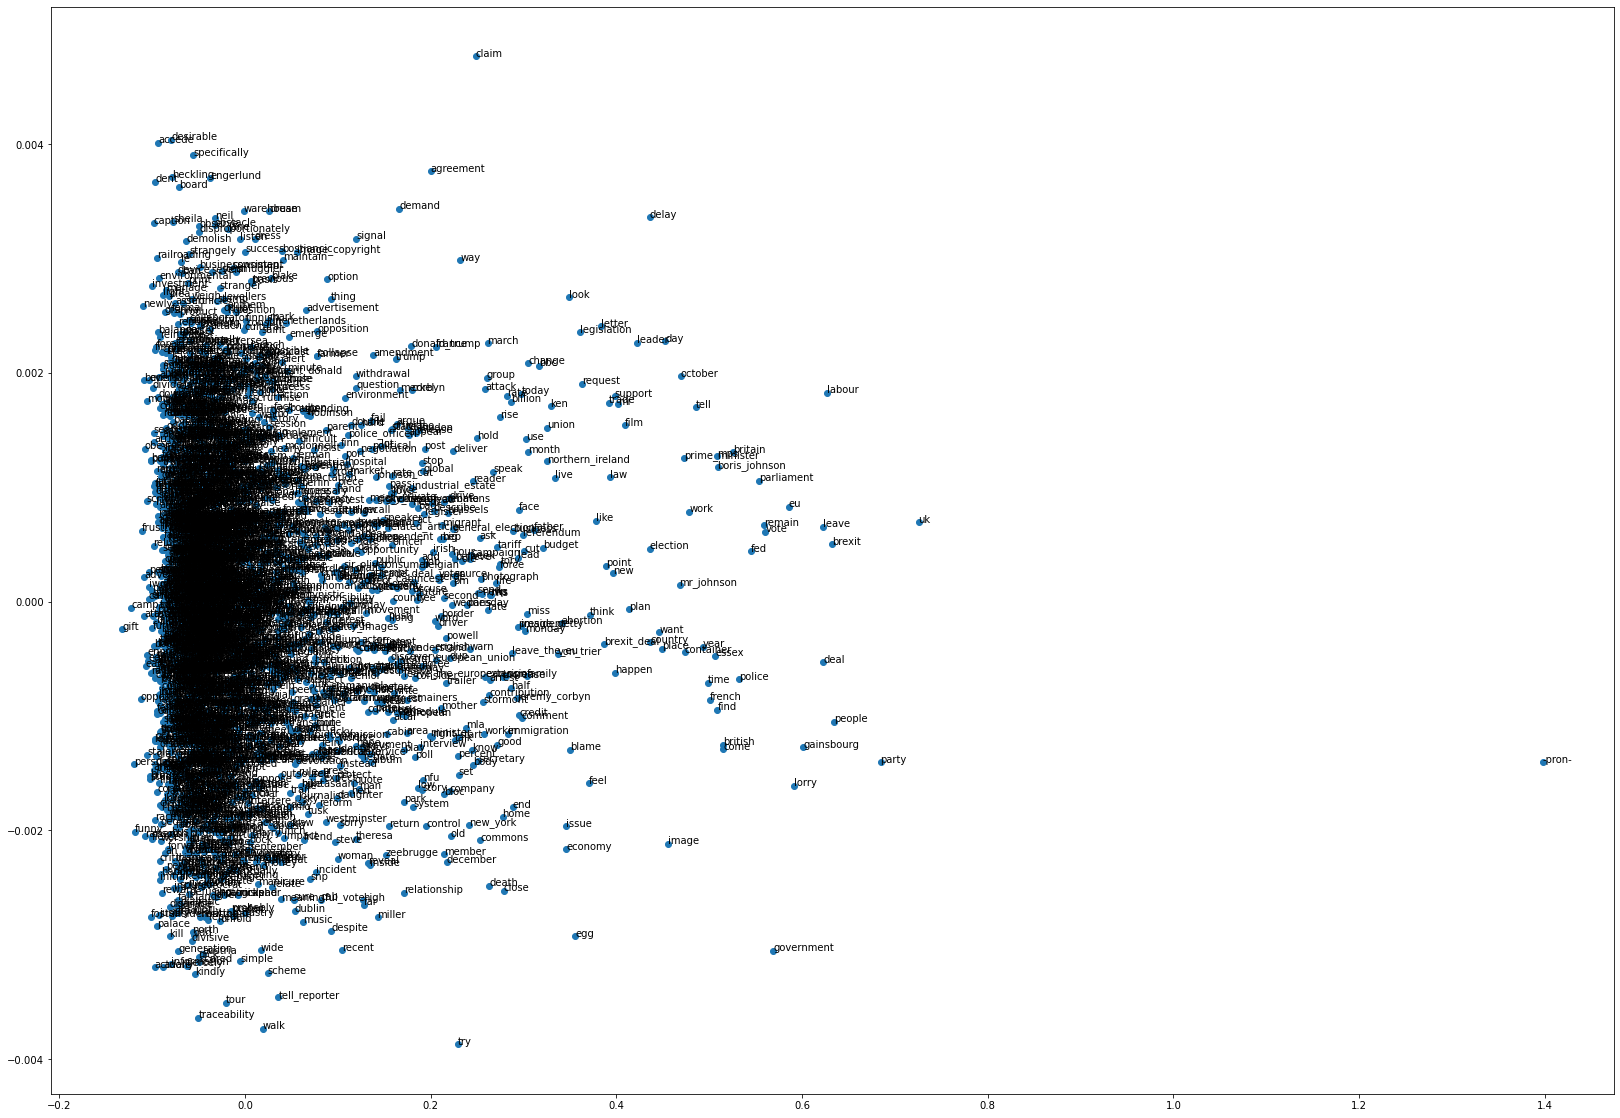

In [42]:
# Fit Principal component analysis (PCA) on the skipgram model output and plot the first 2 components

data = skipgram[skipgram.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(data)
# create a scatter plot of the projection
plt.figure(figsize=(28,20))
plt.scatter(result[:, 0], result[:, 1])
words = list(skipgram.wv.vocab)

for i, word in enumerate(words):
       plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()


## Acknowledgements

1. Akshay Kulkarni and Adarsha Shivananda. 2019. Natural Language Processing Recipes. [Chapter 3: Converting Text to Features](https://learning.oreilly.com/library/view/natural-language-processing/9781484242674/html/475440_1_En_3_Chapter.xhtml#)

2. [Sklearn's module on feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html)
3. [Vector Semantics and Embeddings](https://web.stanford.edu/~jurafsky/slp3/6.pdf) in _Speech and Language Processing_. Daniel Jurafsky & James H. Martin. Copyright 2020. Draft of December 30, 2020.